# Modelling uncertainty and correlation in multivariate linear regression using affine transformation from Gaussian parameter space to the linear domain.
## This article explores the ability of Bayesian models to learn the generative distribution properties of linear data using multivariate Gaussian priors and hence gain more informative posteriors than we normally obtain from line fitting regression. Implemented in Python with PyMC3.
![Bayesian Inference](http://www.appliedmachinelearning.ai/assets/images/pymc3_trajectory_model/grw_result_3d.png "Modelling uncertainty and correlation in multivariate linear regression using affine transformation from Gaussian parameter space to the linear domain using PyMC3")
## Overview
It seems an obvious statement not always appreciated that Bayesian linear regression is not fitting points to a line, it is fitting points to Gaussian distributions.

The line is an abstraction. The apparent scatter is because each point is lying on its own surface, based on a starting point and trend drawn from these Gaussians. We cannot know the true surface each point is on, unless we have labelled trajectories over time, but we can infer the probability distributions for these starting points and trends. (Here we refer to line and surface interchangeably as being hypersurfaces in one or two dimensions).

### Ordinary Least Squares
The conventional picture of linear regression is of a line drawn through some scatter plot of points. Classic ordinary least square (OLS) assumes there is a single 'best' line and that the points do not lie exactly on the line because of errors in observation and other unobserved independent random effects. Confidence in the solution is represented in terms of the distance of the points from this 'best' line.

### Bayesian Regression
The Bayesian view is that there is not a single 'best' line but a family of lines each of which carries a certain probability of being the 'true' line, based on the given data and priors. Points are not expected to lie on a single surface because there are errors in observations, which can be modelled, and because the slope and intercept of the 'true' line can only be known approximately, and hence these are modelled as distributions.

### Bayesian Regression - a deterministic viewpoint
We want to explore in this article a more ambitious target, based on learning the true shape of the generative distributions. Setting aside observational errors for now, we suggest that the physical reality underlying the Bayesian interpretation is not that there is a single 'true' line which we are trying to find from inherently noisy data, but that there are many actual 'true' trajectories, each of which generates linear data points in a deterministic way. The scatter in the data is not inherent but is a consequence of our lack of knowledge of the start conditions for each trajectory; there are many trajectories in our observed system, arising from the complex underlying processes which generate these trajectories. The distribution shape of the trajectories' initial conditions tells us about these underlying processes.

The objective in Bayesian linear regression is not just to get the 'best' line - it is very possible to obtain an incorrect but well-fitting model - our objective is to model as accurately as possible the properties of the distributions that represent the physical processes from which our observed data is drawn. This includes separating noise terms from other uncertainties so that we can understand both the underlying deterministic and stochastic physical processes giving us not just a descriptive but an explanatory model which transcends the sample domain. The probability distributions we use in solving these problems are not artifacts or tricks, but should be interpreted as revealing something true about the physical priors.

We can interpret linear models as a special case of Gaussian models, with a constraint across datapoints in a particular dimension, in a similar way that Gaussian Processes (GP) are Gaussian models constrained by a smoothing kernel across adjacent datapoints. The line, or curve in GP, or surface in the multivariate case, is an abstraction influenced by our ability to visualize it. Then a linear mixed model is essentially a Gaussian mixture model with additional linear constraints.

## Gaussian affine transformation
We use below the property that Gaussians under linear transformation of Gaussian X by a linear transformation A, with scalar vector b, Y = A.x + b, remain Gaussians. Then Y has mean mu = b + A.mu_x and covariance = A.sigma_x.A(T).

#### 0.1 Regression surface
We assume that every observable $z$ at point $x$ is evidence of an underlying model in $intercept$ and slope $β$:

$z_{obs} = intercept + x\cdotβ$

We assume that there exist probability distributions for the intercept and slope of our system:

$ I \sim \mathcal{N}(\mu_{intercept},\,\Sigma_{intercept})\,$

$ B \sim \mathcal{N}(\mu_\beta,\,\Sigma_\beta)\,$

Then $intercept$ and $β$ are drawn from these distributions and we are looking for the probability of an observation $z_{obs}$ at a point $x$ given these assumptions.

#### 0.2 Affine transformation
For a Gaussian, an affine transformation of $B$ by $X$ of the form $Y=i + XB$, where $i$ is a constant vector, gives a new Gaussian:

$ Y \sim \mathcal{N}(\mu_y,\,\Sigma_y)\,$ where $\mu_y=i + X\mu_\beta$ and $\Sigma_y=X\Sigma_\beta X^T$

This is close to what we want, but we must also consider that our intercept is not a constant vector but is also drawn from a distribution. This has a 'defocussing' effect on $y$ since for each draw of the slope $β$ at point $x$, there will an uncertainty in the value of $y$ corresponding to the uncertainty in the draw of the intercept. This amounts to a convolution of the $Y$ distribution with the distribution for $I$. Each possible distribution of $y$ is convoluted with a mean shifted by each possible draw of $intercept$, which has the effect of spreading the uncertainty in $y$:

#### 0.3 Convolution of Intercept and Slope

$Z = Y \circledast I$

The useful property of Gaussians is that the variance of the convolution is the sum of the variances of the contributing distributions, hence we obtain the result we want for the distribution of observables of z at a point x:

$Z \sim \mathcal{N}(\mu_z,\,\Sigma_z)\,$ where $\mu_z=\mu_{intercept} + X\mu_\beta$ and $\Sigma_z=\Sigma_{intercept} + X\Sigma_\beta X^T$

In the case where $x$ is a constant vector with the same number of elements as $β$, which is our case for $z_{obs}$ we obtain

$Z \sim \mathcal{N}(\mu_{intercept} + x\cdot{\mu_β}, x\Sigma_\beta x^T)$

#### 0.4 Distributions for Affine Linear Regression

In our bivariate case, the slope $β$ is composed of $β_x$ and $β_y$ and each sample point in $X$ is a coordinate $x$, $y$, hence:

$\mu_z = \mu_{intercept} + x\cdot\mu_β = \mu_{intercept} + x \mu_{\beta x} + y\mu_{\beta y}$

$\Sigma_z = \Sigma_{intercept} + [x, y]\cdot\begin{bmatrix}
\Sigma_{\beta xx} & \Sigma_{\beta xy}\\
\Sigma_{\beta yx} & \Sigma_{\beta yy}
\end{bmatrix}\cdot[x, y]^T$

Also note below that for the univariate distributions $I$ and $Z$, $\Sigma_{intercept} = \sigma_{intercept} ^ 2$ and $\Sigma_z = \sigma_z ^ 2$

### Implementation
Below we are creating a simple exploration of these ideas solving a multivariate linear regression model using PyMC3. Article roadmap is as follows:

1. Verify numerically that the calculated affine distribution above correctly mimics test values of $z$ calculated in the $xy$ domain from samples drawn from the test intercept and slope distributions
2. Show that taking the samples of *slope* as observables, the PyMC3 model of the Gaussian distribution of $B$ yields good values for the mean and covariance, $\mu_\beta,\,\Sigma_\beta$ of this distribution
3. Setup the PyMC3 using the affine distribution $Z$ and show that taking the samples of $z$ as observables we can obtain good values for the parameters of distributions $I$ and $B$, being $\mu_{intercept},\,\sigma_{intercept}, \mu_\beta,\,\Sigma_\beta$
4. Compare our affine approach against the conventional linear regression approach, modelling unconnected slope and intercept priors along with a noise prior
5. Modify the conventional approach by adding covariance and mean to slope and compare against our affine regression approach
6. Conclusion

In [1]:
%matplotlib inline
#%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib import cm
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
import scipy.stats as st
import theano
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

RANDOM_SEED = 8924

# Grid sample space
x_abs_min, x_abs_max = 6, 7
y_abs_min, y_abs_max = 6, 7
obs_delta = (1, 1) # interval steps in sample space x, y
z_abs_min, z_abs_max = 30, 30
z_abs_min_t, z_abs_max_t = 35, 35 # used for contours but not for axes

# Plot theme
sns.set_style("white")
pal_1 = sns.light_palette('green')
pal_2 = sns.light_palette('blue')
pal_3 = sns.light_palette('red')
colormap = cm.coolwarm(np.linspace(0, 1, x_abs_max))

# Plot scaling
fig_size_x, fig_size_y = 12, 6

# Sampling
samples_predictive = 750
tune_predictive = 500

xy_true = np.mgrid[-x_abs_min:x_abs_max+.1:obs_delta[0], -y_abs_min:y_abs_max+.1:obs_delta[1]]

Running on PyMC3 v3.11.2


In [2]:
# Credit https://docs.pymc.io/notebooks/LKJ.html
np.random.seed(RANDOM_SEED) 
n_trajectories = 700
observations_per_surface = 3

σ_noise = 2.0 # Observational noise

μ_intercept = 4.0
σ_intercept = 0.9

μ_slope = np.array([
    [2.0, 1.5], # Mean of Slope 0
    ])
    
σ_slope = np.array([
    [1, 0.7], # Sigma of Slope 0
    ])

ρ = -0.4 # correlation os Slope 0
ρ_slope = np.matrix([
    [1.0, ρ], [ρ, 1.0]
    ])

Σ_slope = np.asarray(np.diag(σ_slope[0]) * ρ_slope * np.diag(σ_slope[0]))

intercept = np.random.normal(μ_intercept, σ_intercept, size=n_trajectories)
slope = np.random.multivariate_normal(μ_slope[0], Σ_slope, size=n_trajectories)
slope[0] = μ_slope[0] # set element zero to 'actual'
Σ_slope

array([[ 1.  , -0.28],
       [-0.28,  0.49]])

In [3]:
def get_default_trajectory(xy_mesh, intercept, slope):
    return (np.dot(xy_mesh.T, slope.T) + intercept).T

def get_xy(test_coords, el):
    x, y = get_xy_index(test_coords[el])
    return xy_true[0, x, y], xy_true[1, x, y]

def get_xy_index(test_coord):
    return test_coord[0], test_coord[1]

In [4]:
z_true = get_default_trajectory(xy_true, intercept, slope)

In [5]:
def plot_3d_grid(ax, title):
    ax.set_title(title)
    ax.set_xlabel(f'$x, [delta_x = {obs_delta[0]}]$')
    ax.set_ylabel(f'$y, [delta_y = {obs_delta[1]}]$')
    ax.set_zlabel(f'$z$')
    ax.set_xlim3d(-x_abs_min, x_abs_max)
    ax.set_ylim3d(-y_abs_min, y_abs_max)
    ax.set_zlim3d(-z_abs_min, z_abs_max)

def plot_3d_model(ax, mesh, z_mesh, title, layers_to_plot, xy_obs=None, z=None):
    x, y = mesh[0], mesh[1]
    plot_3d_grid(ax, title)
    
    if layers_to_plot == 0:
        layers_to_plot = z_mesh.shape[0]
        
    if xy_obs is None:
        ax.plot_wireframe(x, y, z_mesh[0]*0, color='g', label='Zero xy plane')
        ax.plot_wireframe(x, y, z_mesh[0], color='b', label='Mean $P(β|x,y)$')
        plt.legend(loc=2, shadow=True)
    else:
        ax.contourf(x, y, z_mesh[0], zdir='z', offset=-z_abs_min, cmap=cm.coolwarm, alpha=.8)
        ax.plot_wireframe(x, y, z_mesh[0], color='b', alpha=0.4, label='Mean $P(β|x,y)$')
        
        show_label = z.shape[0] <= 10
        for i in range(z.shape[0]):
            x_i = xy_obs[i,0] + x_abs_min
            c = colormap[int(x_i%x_abs_max)] # color based on the x index
            ax.scatter(xy_obs[i,0], xy_obs[i,1], z[i,1:], depthshade=False, alpha=0.07, color=c, marker='.')
            l = ''
            if show_label:
                l = f'xy={xy_obs[i]}'
            ax.scatter(xy_obs[i,0], xy_obs[i,1], z[i,0], depthshade=False, alpha=0.9, color=c, marker='o', label=l) # mark origin
            
    for i in range(0, layers_to_plot):
        ax.plot_wireframe(x, y, z_mesh[i], color=colormap, alpha=.1)
        
    plt.legend(loc=2, shadow=True)

## 1. Generated sample data
Often practical discussions of linear regression start by simulating test data, adding random noise to a sample linear dataset. While this achieves the objective of verifying the robustness of linear model to the random error term, it does nothing to test the ability of the model to reflect the uncertainty in the intercept and gradient.

To properly test the model performance we must simulate data by drawing intercept and gradient from simulated distributions, generating linear points across this line and then adding noise. This must be done for samples across these distributions and the modelled posterior distributions must be checked to see that they correctly reproduce the parameters of the sample distributions. Hence we move away from the notion that there is a single 'true' line which we are trying to model, and instead give full status to the parameters of the generating distributions as saying something about the underlying causal behaviour.

It can clearly be seen below that, as is expected, the sampled surfaces drawn from our intercept and slope distributions diverge from the mean plan with increasing values of x and y. Data observed in this domain might appear to exhibit errors that are non homoscedastic, but that would be an incorrect interpretation of the data. The diverging data distribution in the xy plane arises from the spatial transformation of a normal distribution to the linear domain.

For the purposes of the ongoing tests we are deliberately not adding noise to our sampled data so that we can test the hypothesis that we can uncover the true parameter distributions from the apparently noisy data. These parameters are effectively latent variables. We cannot observe them directly, but only their effect in a transformed space.

Here we calculate the observable value $z$ at each point $X$ in the plane for each draw sample of $intercept$ and slope $β$

$z_{sample} = intercept_{sample} + X\cdotβ_{sample}$

Text(0.5, 0.98, 'Sampled planes rendered from Intercept and Slope distributions')

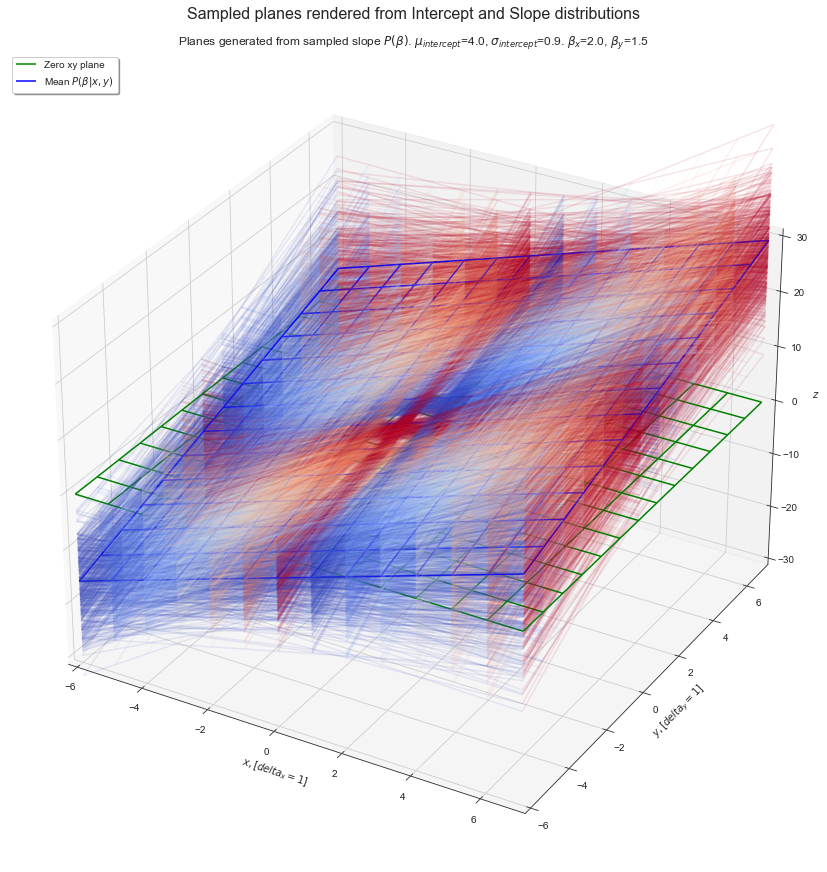

In [6]:
def get_text_header(μ_i, σ_i, μ_β):
    return ' $μ_{intercept}$=' + f'{np.round(μ_i,2)}' + ', $σ_{intercept}$=' + f'{np.round(σ_i,2)}' + '. $β_x$=' + f'{np.round(μ_β[0],2)}' + ', $β_y$=' + f'{np.round(μ_β[1],2)}'
    
fig = plt.figure(figsize=(fig_size_x, fig_size_y*2), constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=1)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
plot_3d_model(ax1, xy_true, z_true, 'Planes generated from sampled slope $P(β)$.' + get_text_header(μ_intercept, σ_intercept, μ_slope[0]), 300)
fig.suptitle('Sampled planes rendered from Intercept and Slope distributions', fontsize=16)

### 1.1 Test data points
In order to visualize the behaviour of the model, we devise a set of 9 data points in the xy plane at which we will evaluate the projected line paths and predicted observations.

In [7]:
def create_test_coords():
    test_coords = np.array([
        [0,0],[0,6],[0,12],
        [6,0],[6,6],[6,12],
        [12,0],[12,6],[12,12]
    ])

    xy_obs = np.zeros(shape=(len(test_coords), 2))
    z_obs = np.zeros(shape=(len(test_coords), n_trajectories))

    for i in range(len(test_coords)):
        x, y = get_xy_index(test_coords[i])
        z_obs[i] = z_true[:, x, y]
        xy_obs[i] = np.array([get_xy(test_coords, i)])
        
    return xy_obs, z_obs

### 1.2 Constructing a Gaussian linear model using Affine transformation and Convolution
In order to use the Bayesian approach we need to form a likelihood function which will map our prior distributions onto points in the linear space of observations.

Here we use the affine transformation in 2 dimensions, which has the effect of projecting our multivariate slope and intercept distributions onto a univariate distribution which gives the probability of an observation having a certain value at each point x, y in the linear domain.

At each point x,y, the observational distribution has the following form:

$\mu_z = \mu_{intercept} + x\cdot\mu_β$

$\sigma_z = \sqrt{\sigma_{intercept} ^2 + [x, y]\cdot\begin{bmatrix}
\Sigma_{\beta xx} & \Sigma_{\beta xy}\\
\Sigma_{\beta yx} & \Sigma_{\beta yy}
\end{bmatrix}\cdot[x, y]^T}$

In [8]:
def plot_pdf_item_from_dist(i, label, xy, z, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles):
        x_i, y_i = xy[0] + x_abs_min, xy[1] + y_abs_min
        mu = μ_intercept + np.dot(xy, μ_β.T).item(0) # mu_z = μ_intercept + x * β_x + y * β_y$
        sigma = (σ_intercept ** 2 + xy.dot(Σ_β).dot(xy.T).item(0)) ** 0.5 # Note: sigma of convolution of Gaussians g0 and g1 is sqrt(sigma_g0^2 + sigma_g1^2)
        x_sample = np.linspace(z_min, z_max, 1000)
        pdf = st.norm.pdf(x_sample, mu, sigma)
        ls = linestyles[int(y_i/y_abs_min)%len(linestyles)] # linestyle based on y index
        d_alpha = 0.2 * y_i/y_abs_min # fade away the y index
        c = colormap[int(x_i%x_abs_max)] # color based on the x index
        if y_max is None:
            d_shift = 0.09 + i/100 # displace scatter plot from top margin and split by group
        else:
            d_shift = y_max*0.6
        l=f'{label}, μ={np.round(mu, 2)}, σ={np.round(sigma, 2)}'
        if fill:
            plt.fill_between(x_sample, pdf, 0, color=c, alpha=0.2, label=l)
            l=''
        plt.plot(x_sample, pdf, alpha=.9, lw=2, label=l, color=c, linestyle=ls)
        if z is not None:
            sns.kdeplot(z, fill=True, alpha=0.6-d_alpha, lw=0, color=c, label=f'KDE of sample data: xy={xy_obs[i]}')
            plt.scatter(z, z*0 + d_shift, alpha=0.1, color=c, marker='.')
            
def plot_pdf(i, label, xy, z, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles):
    if z is None:
        plot_pdf_item_from_dist(i, label, xy[i], None, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles)
    else:
        plot_pdf_item_from_dist(i, label, xy[i], z[i], z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles)
        
def plot_pdf_from_dist(ax, label, xy, z, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill=False, ip=None, y_max=None, linestyles=None):
    if linestyles is None:
        if ip is None:
            linestyles = ['-', '--', ':']
        else:
            linestyles = ['-']
    if ip is None:
        for i in range(len(xy)):
            plot_pdf(i, label, xy, z, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles)
    else:
        plot_pdf(ip, label, xy, z, z_min, z_max, μ_intercept, σ_intercept, μ_β, Σ_β, fill, y_max, linestyles)
        
    plt.xlim(z_min, z_max)
    if y_max is not None:
        plt.ylim(0, y_max)
    ax.set_xlabel(f'$z$')
    ax.set_ylabel(f'$P(z)$')
    plt.legend(loc=4, shadow=True)

### 1.3 Testing Affine Gaussian distribution against simulated data
It is valuable to compare the analytic affine Gaussian distributions above against the result of simulating the distributions stochastically by drawing samples of the projected plane surfaces.

At each test xy point, each point will have a set of observation values corresponding to the set of drawn intercept and slope samples. These probability densities of the values at these points should correspond to the analytic linear affine transformed distribution.

To test this we:

1. Estimate the sampled population intercept, standard deviation and slope mean and covariance of the draws from the intercept and slope distributions above
2. From these parameters use our affine transformation to obtain transformed mean and covariances at specific test xy points
3. Using the transformed mean and covariance, plot the Gaussian distribution for each of the test points
4. Also plot a kernel density estimate (KDE) of the stochastic observables at these test points

In [9]:
def print_gaussian_terms(label, μ_β, Σ_β):
    print(f'* Sampled slope mean            = {np.round(μ_sample_β,3)}')
    print(f'* Sampled slope covariance      = {np.round(Σ_sample[0],3)},{np.round(Σ_sample[1],3)}')
    print(f'* {label} slope mean            = {np.round(μ_β,3)}')
    print(f'* {label} slope covariance      = {np.round(Σ_β[0],3)},{np.round(Σ_β[1],3)}')
    
def print_linear_terms(label, μ_i, σ_i):
    print(f'* Sampled intercept mean        = {μ_sample_i:.3f}')
    print(f'* Sampled intercept σ           = {σ_sample_i:.3f}')
    print(f'* {label} intercept mean        = {np.round(μ_i,3)}')
    print(f'* {label} intercept σ           = {np.round(σ_i,3)}')
    
Σ_sample = np.cov(slope[:,0], slope[:,1])
μ_sample_β = slope.mean(axis=0)
μ_sample_i = intercept.mean(axis=0)
σ_sample_i = np.std(intercept, axis=0)
print_linear_terms('True', μ_intercept, σ_intercept)
print_gaussian_terms('True', μ_slope, Σ_slope)

* Sampled intercept mean        = 3.996
* Sampled intercept σ           = 0.910
* True intercept mean        = 4.0
* True intercept σ           = 0.9
* Sampled slope mean            = [1.978 1.485]
* Sampled slope covariance      = [ 1.022 -0.283],[-0.283  0.492]
* True slope mean            = [[2.  1.5]]
* True slope covariance      = [ 1.   -0.28],[-0.28  0.49]


### 1.4 Comparison of 'True' and sampled distributions
For the purposes of the tests below, we have drawn a sample set of intercepts and slopes as described above and comparisons of model performance are made against the sampled data, as though it were truth, since without informative priors on the 'truth', the inference cannot do better that reproduce the sampled distributions.

Here we compare the affine transformation of our sample data distributions at each of the test points and compare with the distribution of observations based on those sample distributions. It can be seen that the affine transformations which are generating the Sample PDFs match very closely that KDE estimates of the actual sampled observations. In particular it can be seen that the origin point (0,0) is represented only by the intercept distribution since the slopes at that point have zero contribution.

**Note** In all these charts the solid lines represent PDFs generated as normal distributions with mean and sigma calculated using the affine calculations based on $μ_i, σ_i, μ_β, Σ_β$ at the relevant point xy.

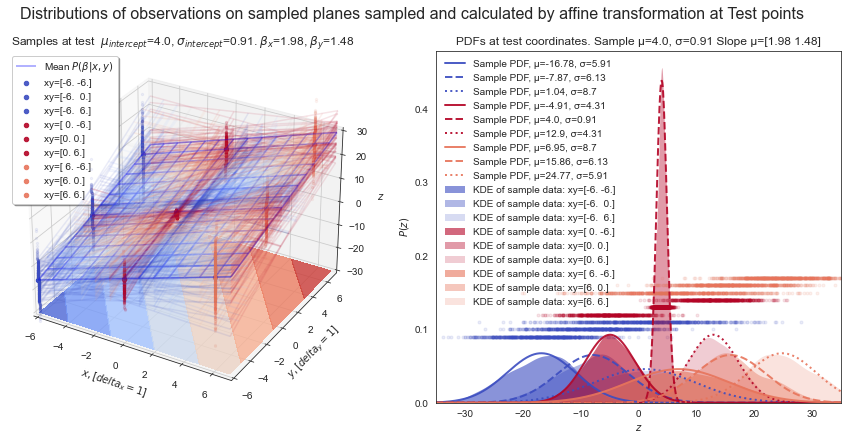

In [10]:
def plot_posterior_results(suptitle, title, xy, z, μ_i, σ_i, μ_β, Σ_β, layers, fill):
    fig = plt.figure(figsize=(fig_size_x, fig_size_y), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1)
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    plot_3d_model(ax1, xy_true, z_true, title + get_text_header(μ_i, σ_i, μ_β), layers, xy, z) # plot first 600 random samples
    ax2 = fig.add_subplot(gs[0, 1])
    if fill:
        plot_pdf_from_dist(ax2, 'Sample PDF', xy_obs, None, -z_abs_min_t, z_abs_max_t, μ_sample_i, σ_sample_i, μ_sample_β, Σ_sample, fill)
        plot_pdf_from_dist(ax2, 'Posterior PDF', xy_obs, None, -z_abs_min_t, z_abs_max_t, μ_i, σ_i, μ_β, Σ_β)
        plt.legend(loc=2)
    else:
        plot_pdf_from_dist(ax2, 'Sample PDF', xy_obs, z, -z_abs_min_t, z_abs_max_t, μ_sample_i, σ_sample_i, μ_sample_β, Σ_sample, fill)
        plt.legend(loc=2, framealpha=0)
    ax2.set_title(f'PDFs at test coordinates. Sample μ={np.round(μ_sample_i, 2)}, σ={np.round(σ_sample_i, 2)} Slope μ={np.round(μ_sample_β, 2)}')
    fig.suptitle(suptitle, fontsize=16)

xy_obs, z_obs = create_test_coords()
    
plot_posterior_results('Distributions of observations on sampled planes sampled and calculated by affine transformation at Test points',
                       'Samples at test ', xy_obs, z_obs, μ_sample_i, σ_sample_i, μ_sample_β, Σ_sample, 40, False)

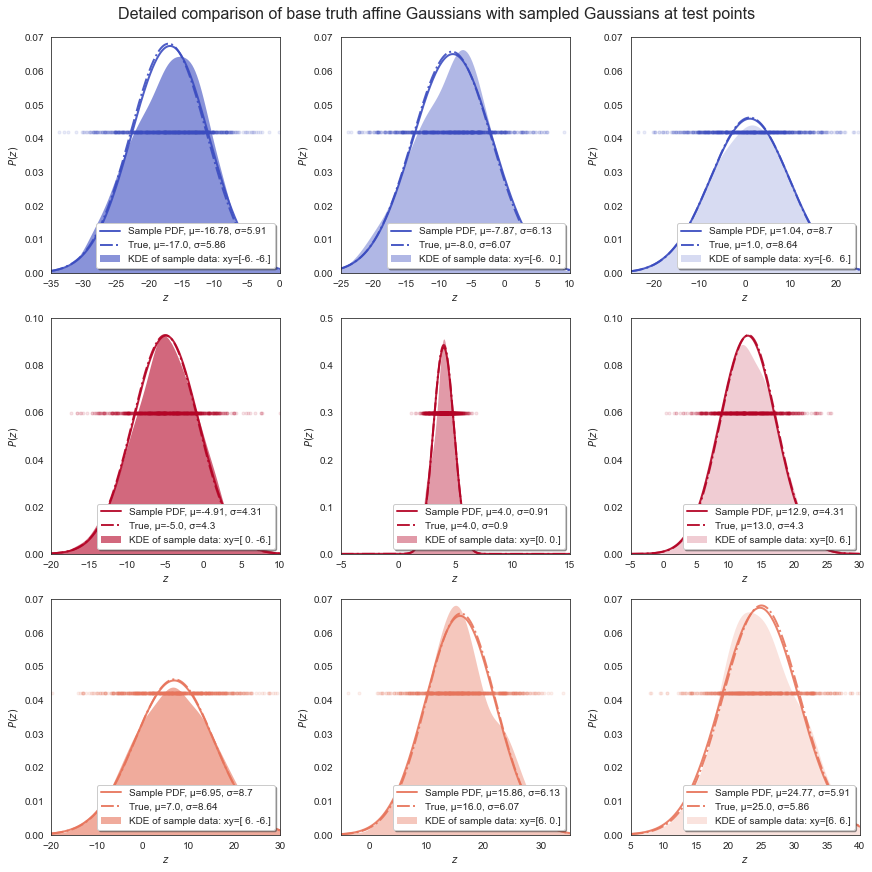

In [11]:
def plot_pdf_detail(fig, gs, xy, z, i, label, μ_intercept, σ_intercept, μ_slope, Σ_slope):
    z_min_max=np.array([[-35, 0, .07],[-25, 10, .07],[-25, 25, .07],[-20, 10, .1],[-5, 15, .5],[-5, 30, .1],[-20, 30, .07],[-5, 35, .07],[5, 40, .07]])
    ax1 = fig.add_subplot(gs[int(i/3),i%3])
    plot_pdf_from_dist(ax1, 'Sample PDF', xy, z, z_min_max[i, 0], z_min_max[i, 1], μ_sample_i, σ_sample_i, μ_sample_β, Σ_sample, False, i, z_min_max[i, 2])
    plot_pdf_from_dist(ax1, label, xy, None, z_min_max[i, 0], z_min_max[i, 1], μ_intercept, σ_intercept, μ_slope, Σ_slope, False, i, z_min_max[i, 2], ['-.'])
    
def plot_pdf_details(xy, z, title, label, μ_intercept, σ_intercept, μ_slope, Σ_slope):
    fig = plt.figure(figsize=(fig_size_x, fig_size_y*2), constrained_layout=True)
    gs = fig.add_gridspec(ncols=3, nrows=3)
    for i in range(len(z)):
        plot_pdf_detail(fig, gs, xy, z, i, label, μ_intercept, σ_intercept, μ_slope, Σ_slope)
    fig.suptitle(title, fontsize=16)
    
plot_pdf_details(xy_obs, z_obs, 'Detailed comparison of base truth affine Gaussians with sampled Gaussians at test points', 'True', μ_intercept, σ_intercept, μ_slope, Σ_slope)

In [12]:
def create_subplot(row, column, b_lim, z_min, z_max): 
    ax = fig.add_subplot(gs[row, column], projection='3d')
    ax.set_xlabel(f'$β_x$')
    ax.set_ylabel(f'$β_y$')
    ax.set_zlabel(f'$z$')
    ax.set_xlim3d(0, b_lim)
    ax.set_ylim3d(0, b_lim)
    ax.set_zlim3d(z_min, z_max)
    return ax

def plot_projections(x, y, xy, z, b_lim, z_min, z_max):
    ax.scatter(x, y, -z_lim, marker='.', color='r', alpha=.4)
    ax.scatter(x, y, z, marker='.')
    ax.scatter(x*0, y, z, marker='.', color='orange', alpha=.2)
    ax.scatter(x, b_lim + y*0, z, marker='.', color='green', alpha=.2)
    k1 = st.kde.gaussian_kde([x,y])
    x1, y1 = np.mgrid[0:b_lim:.1, 0:b_lim:.1]
    z1 = k1(np.vstack([x1.flatten(), y1.flatten()]))
    k2 = st.kde.gaussian_kde([x,z])
    x2, y2 = np.mgrid[0:b_lim:.1, -z_min:z_max:.1]
    z2 = k2(np.vstack([x2.flatten(), y2.flatten()]))
    k3 = st.kde.gaussian_kde([y,z])
    z3 = k3(np.vstack([x2.flatten(), y2.flatten()]))
    ax.contour(x1, y1, z1.reshape(x1.shape), zdir='z', offset=-z_min, cmap=cm.Reds_r, levels=7, alpha=.75)
    ax.contour(x2, z2.reshape(x2.shape), y2, zdir='y', offset=b_lim, cmap=cm.Greens_r, levels=7, alpha=.75)
    ax.contour(z3.reshape(x2.shape), x2, y2, zdir='x', offset=0, cmap=cm.Oranges_r, levels=7, alpha=.75)
    ax.plot([x[0], x[0]], [y[0], y[0]], [-z_lim, z[0]], '-', linewidth=2, color='red')
    ax.plot([x[0], x[0]], [b_lim, y[0]], [z[0], z[0]], '-', linewidth=2, color='green')
    ax.plot([0, x[0]], [y[0], y[0]], [z[0], z[0]], '-', linewidth=2, color='orange')
    plt.title(f'Projection of slope $P(β)$ on coordinate xy={xy}, z mean={np.round(z[0],2)}')

## 2. Modelling Gaussian distributions
If we were doing a conventional Gaussian multivariate model we would now fit these bivariate slope samples to a 2-dimensional covariate matrix (Ref https://docs.pymc.io/notebooks/LKJ.html).

First it is useful to visualize the slope distribution projected using the affine transformation to two of the sample test points in xy:

Text(0.5, 0.98, 'Transformation of slope distributions in $β_x$ and $β_y$ (red) onto observation space z (blue) and projected vs $β_x$ and $β_y$')

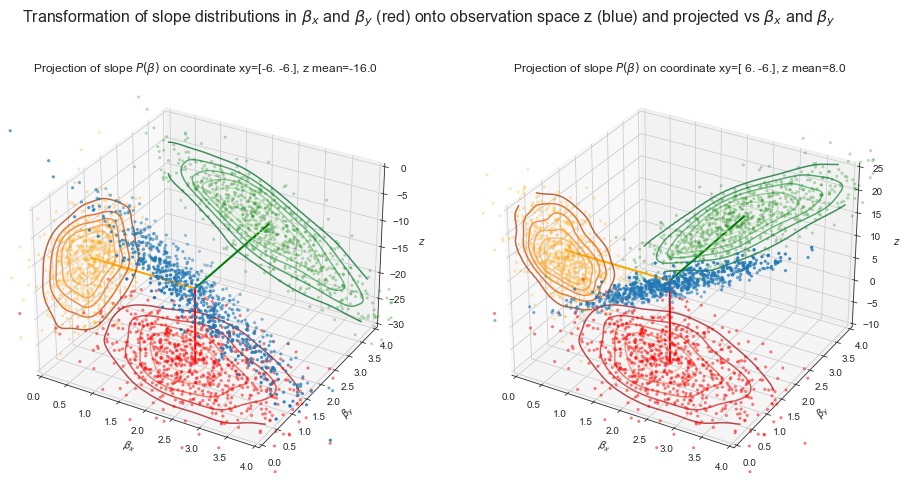

In [13]:
fig = plt.figure(figsize=(fig_size_x*1.3, fig_size_y*1.3))
gs = fig.add_gridspec(ncols=2, nrows=1)
b_lim, z_lim, z_max = 4, 30, 0
ax = create_subplot(0, 0, b_lim, -z_lim, z_max)
plot_projections(slope[:, 0], slope[:, 1], xy_obs[0], z_obs[0], b_lim, z_lim, z_max)
b_lim, z_lim, z_max = 4, 10, 25
ax = create_subplot(0, 1, b_lim, -z_lim, z_max)
plot_projections(slope[:, 0], slope[:, 1], xy_obs[6], z_obs[6], b_lim, z_lim, z_max)
fig.suptitle('Transformation of slope distributions in $β_x$ and $β_y$ (red) onto observation space z (blue) and projected vs $β_x$ and $β_y$', fontsize=16)

### 2.1 Discussion on the uncertainties in the Mean
The most significant change to the documented example is that we use a uniform prior on the slope mean. If a distribution prior is used, such as a Normal, with a meta-prior set on the standard deviation, the result is poorly behaved because the sample mean is a scalar not a distribution. On the assumption of data homogeneity, a sample of means from a population approaches the population mean, hence if we try to fit a distribution we should expect that it will fail. Our best approach is to set a uniform prior across the range of possible values to allow a grid search for the value that best fits our overall model. We can seed this search with the computed mean of the sample data, but this does not necessarily imply that our inferred posterior will have this value.

In [14]:
def create_gaussian_distribution_model(samples, tune, obs):
    with pm.Model() as m:
        μ_β = pm.Uniform("μ_β", 0, 4, shape=2, testval=slope.mean(axis=0)) # mean slope prior
        σ_L = pm.Exponential.dist(1.0) # σ of Cholesky prior
        c_L = pm.LKJCholeskyCov("c_L", n=2, eta=2.0, sd_dist=σ_L) # Cholesky prior
        L = pm.expand_packed_triangular(2, c_L)
        Σ_β = pm.Deterministic("Σ_β", tt.dot(L, L.T))

        obs = pm.MvNormal("o", μ_β, cov=Σ_β, observed=obs)
        trace = pm.sample(samples, tune=tune, cores=4, chains=4, random_seed=RANDOM_SEED, return_inferencedata=False)
        display(az.summary(trace, round_to=3))
        return m, trace, pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED, var_names=['o'])['o']

In [15]:
def print_gaussian_model_results(model, trace):
    Σ_post_β = trace["Σ_β"].mean(axis=0)
    μ_post_β = trace["μ_β"].mean(axis=0)
    print_gaussian_terms('Posterior', μ_post_β, Σ_post_β)
    return μ_post_β, Σ_post_β
        
def print_linear_model_results(model, trace):
    μ_post_β, Σ_post_β = print_gaussian_model_results(model, trace)
    μ_post_i = trace["μ_i"].mean(axis=0)
    σ_post_i = trace["σ_i"].mean(axis=0)
    print_linear_terms('Posterior', μ_post_i, σ_post_i)

    with model:
        az.plot_trace(trace)
        
    return μ_post_i, σ_post_i, μ_post_β, Σ_post_β 

Multivariate Gaussian distribution model results


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_L, μ_β]


Sampling 4 chains for 500 tune and 750 draw iterations (2_000 + 3_000 draws total) took 26 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_β[0]    1.978  0.038   1.907    2.051      0.001    0.000  2989.549   
μ_β[1]    1.485  0.026   1.436    1.534      0.000    0.000  3225.178   
c_L[0]    1.012  0.027   0.963    1.062      0.000    0.000  3554.170   
c_L[1]   -0.278  0.026  -0.324   -0.229      0.000    0.000  3479.724   
c_L[2]    0.644  0.017   0.612    0.676      0.000    0.000  4314.565   
Σ_β[0,0]  1.025  0.054   0.924    1.123      0.001    0.001  3554.170   
Σ_β[0,1] -0.282  0.029  -0.337   -0.230      0.001    0.000  3158.359   
Σ_β[1,0] -0.282  0.029  -0.337   -0.230      0.001    0.000  3158.359   
Σ_β[1,1]  0.494  0.026   0.444    0.542      0.000    0.000  4178.525   

          ess_tail  r_hat  
μ_β[0]    2441.973  1.000  
μ_β[1]    2644.380  1.001  
c_L[0]    2849.619  1.000  
c_L[1]    2522.164  1.003  
c_L[2]    2768.920  1.000  
Σ_β[0,0]  2849.619  1.000  
Σ_β[0,1]  2383.319  1.002  
Σ_β[1,0]  2383.319  1.002  
Σ_β[1,1]  2616.355  1.001

* Sampled slope mean            = [1.978 1.485]
* Sampled slope covariance      = [ 1.022 -0.283],[-0.283  0.492]
* Posterior slope mean            = [1.978 1.485]
* Posterior slope covariance      = [ 1.025 -0.282],[-0.282  0.494]


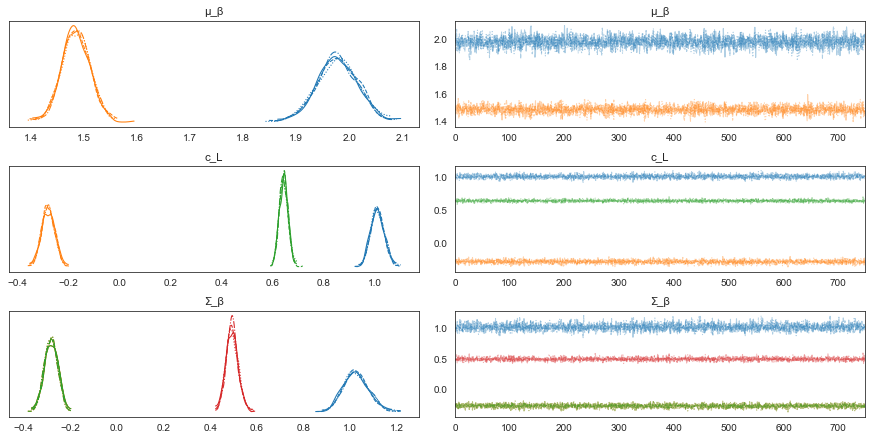

In [16]:
print ('Multivariate Gaussian distribution model results')
print ('================================================')
slope_model, slope_trace, slope_pred = create_gaussian_distribution_model(samples_predictive, tune_predictive, slope)

μ_post_β, Σ_post_β = print_gaussian_model_results(slope_model, slope_trace)

with slope_model:
    az.plot_trace(slope_trace)

### 2.2 Results
Running the model with the uniform prior over 1,800 data points with 5,000 draws over 4 chains is fast, and the result can be seen to be an excellent fit to the ground truth data.

We can also see that the r_hat values are all very close to 1.00 with no divergencies, indicating that the four chains converged smoothly, and posterior traces are very well behaved across all the parameters.

In [17]:
slope_model

## 3. Setting up affine linear regression scenario
In our scenario of linear regression, we cannot directly observe the draws for intercept and slope, but we **can** observe the evolution of a system based on these parameters. Each intercept and slope represents the starting conditions for a surface. Our system will evolve over these surfaces such that every observable data point will lie on one of these surfaces and will have a probability density of values related to its xy coordinate and the distributions of intercept and slope. The shape of the distribution at each point will differ, which would seem to make inference impossible, but the distributions all share the common hidden parameters of the generative distributions. This gives us hope that we will be able to obtain a convergence in the MCMC space.

Note that we intentionally are not attempting to model random noise in the observational data. Our sample does not contain noise and our model does not have a prior to represent it.

In [18]:
def create_test_observables(xy_true, z_true, observations_per_surface):
    z = np.zeros(shape=(z_true.shape[0] * observations_per_surface, 1))
    xy = np.zeros(shape=(z_true.shape[0] * observations_per_surface, 2))

    i_obs = 0
    for i in range(z_true.shape[0]):
        xy_grid = np.random.randint(low=0, high=xy_true.shape[2], size=(2, observations_per_surface))
        for obs in np.array((xy_true[0, xy_grid[0], xy_grid[1]], xy_true[1, xy_grid[0], xy_grid[1]], z_true[i, xy_grid[0], xy_grid[1]])).T:
            z[i_obs] = obs[2]
            xy[i_obs] = obs[0:2]
            i_obs += 1
    return xy, z

xy_test, z_test_array = create_test_observables(xy_true, z_true, observations_per_surface)  

z_test = z_test_array.reshape(z_test_array.shape[0]) # flatten single array points

In [19]:
def create_gaussian_linear_model(samples, tune, xy_obs, obs):
    with pm.Model() as m:
        μ_β = pm.Uniform("μ_β", 0, 4, shape=2) # mean slope prior
        σ_i = pm.HalfCauchy("σ_i", beta=1) # σ of mean intercept prior
        μ_i = pm.Normal("μ_i", 0, sigma=σ_i) # mean intercept prior
        μ_obs = μ_i + tt.dot(xy_obs, μ_β.T).flatten() # inferred μ of observed linear projection
        
        σ_L = pm.Exponential.dist(1.0) # σ of Cholesky prior
        c_L = pm.LKJCholeskyCov("c_L", n=2, eta=2.0, sd_dist=σ_L) # Cholesky prior
        L = pm.expand_packed_triangular(2, c_L)
        Σ_β = pm.Deterministic("Σ_β", tt.dot(L, L.T))
        σ_obs = (σ_i ** 2 + tt.dot(tt.dot(xy_obs, Σ_β), xy_obs.T).diagonal()) ** 0.5 # inferred σ of observed linear projection

        obs = pm.Normal('o', mu=μ_obs, sigma=σ_obs, observed=obs)
        trace = pm.sample(samples, tune=tune, cores=4, chains=4, random_seed=RANDOM_SEED, return_inferencedata=False)
        display(az.summary(trace, round_to=3))
        return m, trace, pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED, var_names=['o'])['o']

Affine Gaussian linear regression model results


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_L, μ_i, σ_i, μ_β]


Sampling 4 chains for 500 tune and 750 draw iterations (2_000 + 3_000 draws total) took 692 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_i       4.002  0.075   3.853    4.133      0.001    0.001  4137.328   
μ_β[0]    1.957  0.029   1.903    2.012      0.001    0.000  3094.786   
μ_β[1]    1.546  0.024   1.499    1.588      0.000    0.000  3096.846   
σ_i       0.964  0.101   0.782    1.153      0.002    0.001  3591.291   
c_L[0]    1.012  0.026   0.960    1.057      0.000    0.000  2887.226   
c_L[1]   -0.279  0.031  -0.335   -0.221      0.001    0.000  3623.592   
c_L[2]    0.650  0.025   0.602    0.696      0.000    0.000  2870.098   
Σ_β[0,0]  1.024  0.052   0.922    1.117      0.001    0.001  2887.226   
Σ_β[0,1] -0.283  0.032  -0.344   -0.225      0.001    0.000  3453.004   
Σ_β[1,0] -0.283  0.032  -0.344   -0.225      0.001    0.000  3453.004   
Σ_β[1,1]  0.502  0.035   0.439    0.570      0.001    0.000  3087.362   

          ess_tail  r_hat  
μ_i       2213.151  1.002  
μ_β[0]    2370.678  1.001  
μ_β[1]    2263.386  1.001  
σ_i       2459.122  0.999  
c_L[0]    2212.202  1.000  
c_L[1]    2611.876  1.001  
c_L[2]    2522.658  1.000  
Σ_β[0,0]  2212.202  1.000  
Σ_β[0,1]  2676.812  1.001  
Σ_β[1,0]  2676.812  1.001  
Σ_β[1,1]  2312.312  1.001

* Sampled slope mean            = [1.978 1.485]
* Sampled slope covariance      = [ 1.022 -0.283],[-0.283  0.492]
* Posterior slope mean            = [1.957 1.546]
* Posterior slope covariance      = [ 1.024 -0.283],[-0.283  0.502]
* Sampled intercept mean        = 3.996
* Sampled intercept σ           = 0.910
* Posterior intercept mean        = 4.002
* Posterior intercept σ           = 0.964


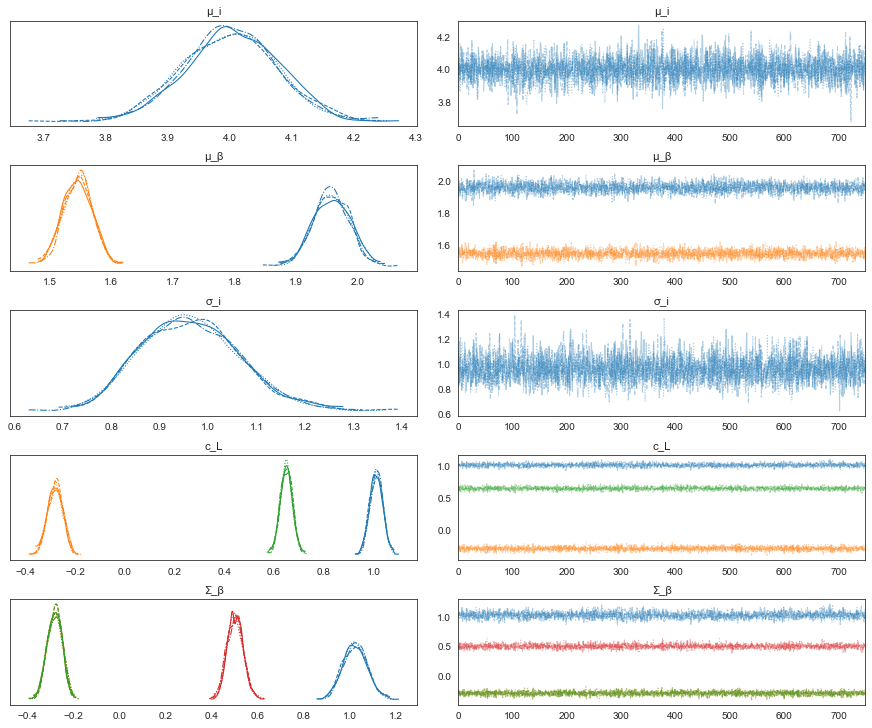

In [20]:
print ('Affine Gaussian linear regression model results')
print ('===============================================')
affine_model, affine_trace, affine_pred = create_gaussian_linear_model(samples_predictive, tune_predictive, xy_test, z_test)  

μ_post_i, σ_post_i, μ_post_β, Σ_post_β = print_linear_model_results(affine_model, affine_trace)

In [21]:
affine_model

### 3.1 Results of affine model run
We can see above that the model has converged very cleanly with no divergences and r_hat close to 1.00. Also we see that the slope and intercept means are close to the expected sample values.

Of the greatest significance, and the distinct feature of the success of our approach, we can see that we have obtained good estimates for both the diagonal and correlation components of the covariance matrix. When we consider that these components are only indirectly related to the observed data and although they influence the slopes in x and y they cannot be directly inferred from those slopes, it is truly an aggregate behaviour of the model over many point distributions that yields these latent values.

The robustness of the convergence, given a relatively small amount of data, suggests that there is great scope for extending this model to cover mixed models with more granular structure to the intercept and slope distributions.

As we would expect the mean posterior samples lie on the expected mean plane of our distributed data:

Text(0.5, 0.98, 'Simulated sampled points and posterior mean showing match to acutal mean plane')

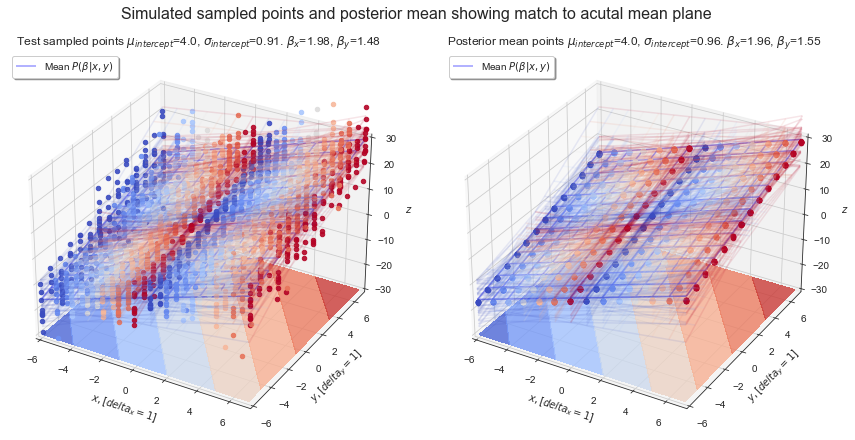

In [22]:
fig = plt.figure(figsize=(fig_size_x, fig_size_y), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=1)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
plot_3d_model(ax1, xy_true, z_true, 'Test sampled points' + get_text_header(μ_sample_i, σ_sample_i, μ_sample_β), 30, xy_test, z_test_array)
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
plot_3d_model(ax2, xy_true, z_true, 'Posterior mean points' + get_text_header(μ_post_i, σ_post_i, μ_post_β), 30, xy_test, affine_pred.mean(axis=0).reshape(affine_pred.shape[1],1))
fig.suptitle('Simulated sampled points and posterior mean showing match to acutal mean plane', fontsize=16)

### 3.2 Visualization of posterior sample points and distributions
It can be seen below that the generated posterior sample points yield distributions that are very close the anticipated sample data distributions. In particular the intercept is well modelled as is the profile of variances at points distant from the origin

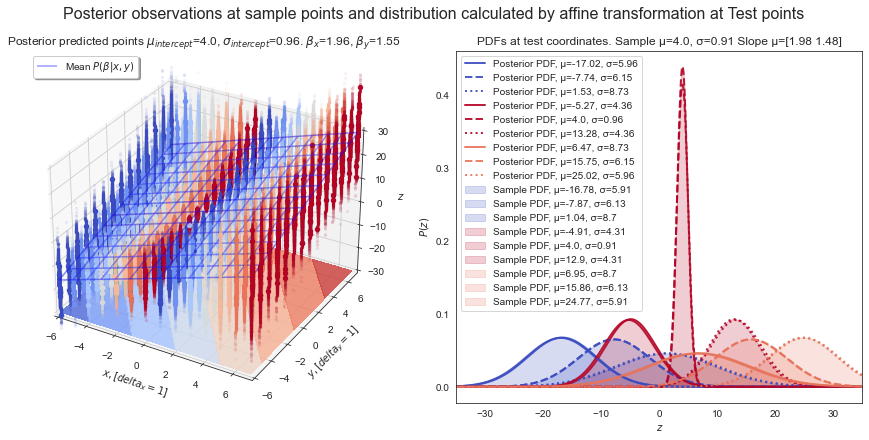

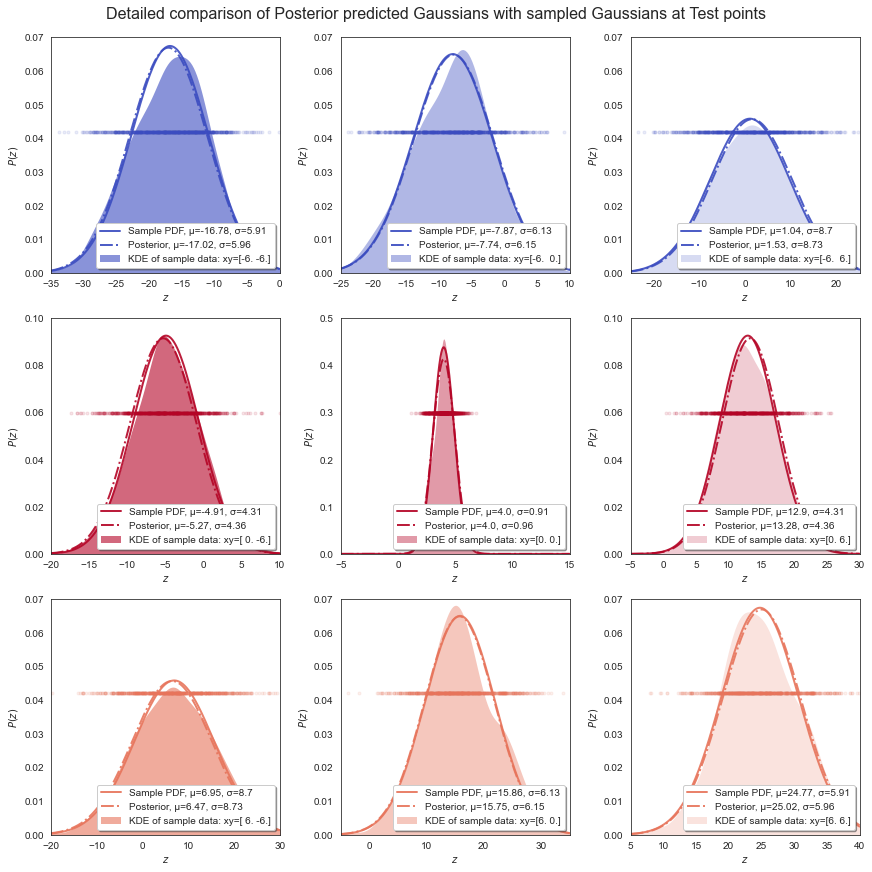

In [23]:
plot_posterior_results('Posterior observations at sample points and distribution calculated by affine transformation at Test points', 
                       'Posterior predicted points', xy_test, affine_pred.T[:,:600], μ_post_i, σ_post_i, μ_post_β, Σ_post_β, 1, True)
plot_pdf_details(xy_obs, z_obs, 'Detailed comparison of Posterior predicted Gaussians with sampled Gaussians at Test points', 'Posterior', μ_post_i, σ_post_i, μ_post_β, Σ_post_β)

## 4. Comparison and contrast with conventional linear regression approach
The conventional approach generally taken to linear regression over sampled n-dimensional observations X is as follows:

1. Create HalfCauchy standard deviation priors $σ_i$, $σ_β$ for intercept and slope
2. Create univariate normal prior for intercept $μ_i$ with mean 0 and standard deviation $σ_i$
3. Create n-dimensional univariate normal priors on slope β with mean 0 and standard deviation $σ_β$
4. Create HalfCauchy standard deviation prior for observations $σ_{noise}$
5. Create univariate normal likelihood with mean $μ_o = μ_i + X\cdotβ$ and standard deviation $σ_{noise}$
6. Condition against observables $y_{obs}$ at points $X$

The $σ_{noise}$ term is essentially an artifact to catch errors which arise because we have properly modelled the prior distributions. This can be seen when we run this model on our sample data:

In [24]:
def create_simple_linear_model(samples, tune, xy_obs, obs):
    with pm.Model() as m:
        σ_i = pm.HalfCauchy("σ_i", beta=1) # σ of mean intercept prior
        μ_i = pm.Normal("μ_i", 0, sigma=σ_i) # mean intercept prior

        β = pm.Normal('β', mu=0, sigma=20, shape=2) # inferred slope
        μ_obs = μ_i + tt.dot(xy_obs, β.T).flatten() # inferred μ of observed line
        
        σ_noise = pm.HalfCauchy("σ_noise", beta=10)
        o = pm.Normal('o', mu=μ_obs, sigma=σ_noise, observed=obs)
        trace = pm.sample(samples, tune=tune, cores=4, chains=4, random_seed=RANDOM_SEED, return_inferencedata=False)
        display(az.summary(trace, round_to=3))
        return m, trace, pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED, var_names=['o'])['o']

In [25]:
print ('Simple linear regression model results')
print ('============================================')
simple_linear_model, simple_linear_trace, simple_linear_pred = create_simple_linear_model(samples_predictive, tune_predictive, xy_test, z_test)

Simple linear regression model results


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_noise, β, μ_i, σ_i]


Sampling 4 chains for 500 tune and 750 draw iterations (2_000 + 3_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8831538258596477, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_i      4.029  0.111   3.827    4.238      0.002    0.001  2907.981   
β[0]     1.940  0.028   1.885    1.993      0.001    0.000  2803.800   
β[1]     1.542  0.026   1.494    1.594      0.001    0.000  2621.789   
σ_i      5.310  6.339   1.271   12.427      0.183    0.129  2268.818   
σ_noise  5.068  0.078   4.922    5.210      0.001    0.001  3623.361   

         ess_tail  r_hat  
μ_i      2069.702  1.000  
β[0]     2236.166  1.000  
β[1]     2036.299  1.002  
σ_i      1484.250  1.004  
σ_noise  2307.511  1.000

### 4.1 Results of conventional linear regression model
Clearly the means compare well with target, which is to be expected as these are conditioned directly by the observables, but we have no correlation coefficients and the standard deviations $σ_i$ and $σ_{noise}$ are very large, as they must absorb all the errors which are artifacts due to the weak model.

## 5. Modification of conventional multivariate linear regression approach
We can try to improve the results of our conventional approach by making the following changes for the slope prior β:

1. Include a uniform prior $μ_β$ as earlier to obtain the mean slope
2. Instead of an n-dimensional univariate normal priors on $β$, use a multivariate normal, with covariance $Σ_β$, conditioned on the Cholesky prior as earlier.

In [26]:
def create_flat_linear_model(samples, tune, xy_obs, obs):
    with pm.Model() as m:
        μ_β = pm.Uniform("μ_β", 0, 4, shape=2) # mean slope prior
        σ_i = pm.HalfCauchy("σ_i", beta=1) # σ of mean intercept prior
        μ_i = pm.Normal("μ_i", 0, sigma=σ_i) # mean intercept prior

        σ_L = pm.Exponential.dist(1.0) # σ of Cholesky prior
        c_L = pm.LKJCholeskyCov("c_L", n=2, eta=2.0, sd_dist=σ_L) # Cholesky prior
        L = pm.expand_packed_triangular(2, c_L)
        Σ_β = pm.Deterministic("Σ_β", tt.dot(L, L.T))

        β = pm.MvNormal('β', mu=μ_β, cov=Σ_β, shape=2) # inferred slope
        μ_obs = μ_i + tt.dot(xy_obs, β.T).flatten() # inferred μ of observed line
        
        σ_noise = pm.HalfCauchy("σ_noise", beta=10)
        o = pm.Normal('o', mu=μ_obs, sigma=σ_noise, observed=obs)
        trace = pm.sample(samples, tune=tune, cores=4, chains=4, random_seed=RANDOM_SEED, return_inferencedata=False)
        display(az.summary(trace, round_to=3))
        return m, trace, pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED, var_names=['o'])['o']

Simple MV linear regression model results


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_noise, β, c_L, μ_i, σ_i, μ_β]


Sampling 4 chains for 500 tune and 750 draw iterations (2_000 + 3_000 draws total) took 49 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6925735140134311, but should be close to 0.8. Try to increase the number of tuning steps.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7104104775358143, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ_i       4.030   0.103   3.835    4.213      0.005    0.003   534.113   
β[0]      1.940   0.028   1.887    1.993      0.001    0.001   413.729   
β[1]      1.542   0.028   1.487    1.590      0.001    0.001   639.499   
μ_β[0]    1.972   0.663   0.621    3.413      0.030    0.022   502.604   
μ_β[1]    1.627   0.747   0.013    2.956      0.033    0.025   488.215   
σ_i       5.141  16.046   1.277   11.271      0.534    0.378   329.585   
c_L[0]    0.878   0.812   0.060    2.272      0.039    0.028   192.144   
c_L[1]    0.025   0.676  -1.247    1.301      0.038    0.032   563.281   
c_L[2]    0.831   0.776   0.096    2.225      0.043    0.030   143.865   
Σ_β[0,0]  1.431   3.462   0.004    5.162      0.111    0.079   192.144   
Σ_β[0,1]  0.043   0.842  -1.053    1.347      0.037    0.026   985.147   
Σ_β[1,0]  0.043   0.842  -1.053    1.347      0.037    0.026   985.147   
Σ_β[1,1]  1.751   4.165   0.009    6.513      0.219    0.155   137.669   
σ_noise   5.062   0.079   4.911    5.205      0.004    0.003   428.798   

          ess_tail  r_hat  
μ_i        703.989  1.010  
β[0]       302.573  1.002  
β[1]       739.394  1.006  
μ_β[0]     497.836  1.015  
μ_β[1]     410.401  1.016  
σ_i        472.373  1.018  
c_L[0]     107.469  1.011  
c_L[1]     314.480  1.020  
c_L[2]     103.934  1.027  
Σ_β[0,0]   107.469  1.011  
Σ_β[0,1]   931.051  1.008  
Σ_β[1,0]   931.051  1.008  
Σ_β[1,1]    89.527  1.028  
σ_noise    590.763  1.012

* Sampled slope mean            = [1.978 1.485]
* Sampled slope covariance      = [ 1.022 -0.283],[-0.283  0.492]
* Posterior slope mean            = [1.972 1.627]
* Posterior slope covariance      = [1.431 0.043],[0.043 1.751]
* Sampled intercept mean        = 3.996
* Sampled intercept σ           = 0.910
* Posterior intercept mean        = 4.03
* Posterior intercept σ           = 5.141


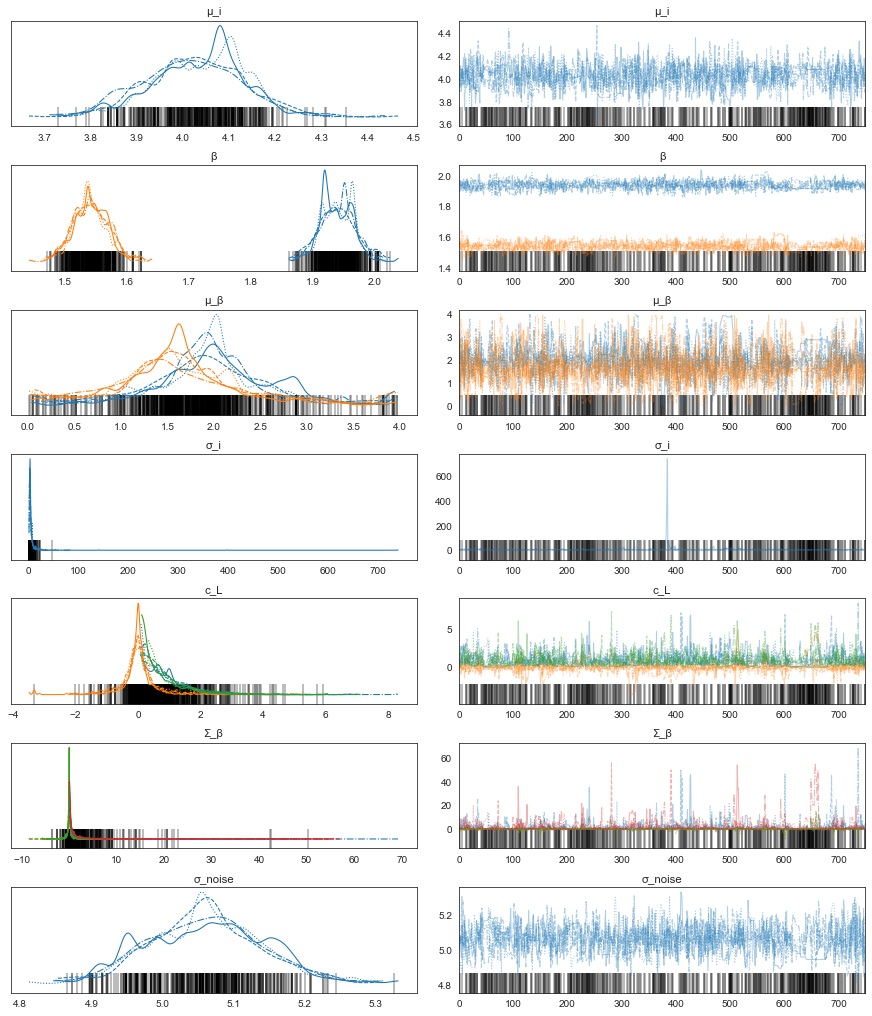

In [27]:
print ('Simple MV linear regression model results')
print ('=========================================')
mv_linear_model, mv_linear_trace, mv_linear_pred = create_flat_linear_model(samples_predictive, tune_predictive, xy_test, z_test)

μ_post_i_f, σ_post_i_f, μ_post_β_f, Σ_post_β_f = print_linear_model_results(mv_linear_model, mv_linear_trace)

## 5.1 Results of multivariate linear regression model based on non-affine approach
It is clear that this revised multivariate model has failed to converge correctly. It has not been able to handle the uncertainties in the Cholesky prior and this has resulted in many divergences. Also, the results for the Covariance posterior are wrong, with close to zero correlation and incorrect variances.

This highlights the problem with the conventional approach. Instead of sampling from a single robust likelihood which correctly models the interaction between the coordinates, intercept and slope priors, where each point in the linear space is fully represented by its own Gaussian distribution, combining all the known information about the expected value at that point, the simple conventional model disconnects the slope prior from the linear space and hence is unable to extract the information in the individual data points.

The posterior means being correct, a naive interpretation of this model would be that we have successfully matched the mean regression surface, and we would imagine we have solved the problem. But if we compare the posterior sample observations and distributions it can be seen that the observations are scattered with a common variance across the linear space and we have lost all of the resolution of the shape of the slope covariant distribution which contributed to the profile of the true sample data.

Hence our predictions of confidence intervals or credibility intervals, on which we might test a hypothesis or use as the basis of downstream analysis, are false to a significant degree.

**Intercept Mean:**
- True μ = 4.000
- Target sample μ = 3.996
- Gaussian regression μ = n/a
- Affine regression μ = 4.002
- Simple regression μ = 4.029
- Simple MV regression μ = 4.030

**Intercept Standard Deviations:**
- True σ = 0.900
- Target sampled σ = 0.910
- Gaussian regression σ = n/a
- Affine regression σ = 0.964
- Simple regression σ = 5.310
- Simple MV regression σ = 5.141

**Slope Means:**
- True μ = (2.000, 1.500)
- Target sample μ = (1.978, 1.485)
- Gaussian regression μ = (1.978, 1.485)
- Affine regression μ = (1.957, 1.546)
- Simple regression μ = (1.940, 1.542)
- Simple MV regression μ = (1.972, 1.627)

**Slope Covariance:**
- True Σ = (1.000, -0.280),(-0.280, 0.490)
- Target sampled Σ = (1.022, -0.283),(-0.283, 0.492)
- Gaussian regression Σ = (1.025, -0.282),(-0.282, 0.494)
- Affine regression Σ = (1.024, -0.283),(-0.282, 0.502)
- Simple regression Σ = n/a
- Simple MV regression Σ = (1.431, 0.043),( 0.043, 1.751)

**Noise terms - non-affine regression artifacts**
- Simple regression noise σ = 5.068
- Simple MV regression noise σ = 5.062

### 5.2 Visualizations of deficiencies in simple multivariate regression
We can see below that the posterior samples from this conventional approach not follow the expected behaviour of our sample data, and that drilling into the detailed distributions at each of the test points it can be seen that the posterior distributions do not match the expected variances.

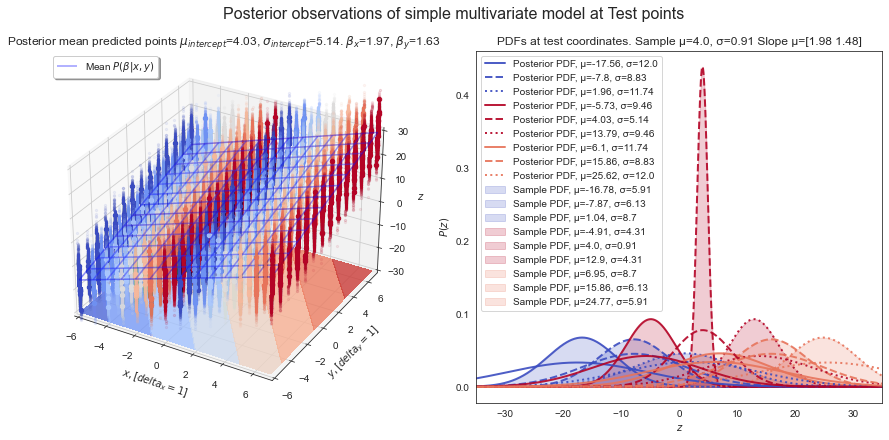

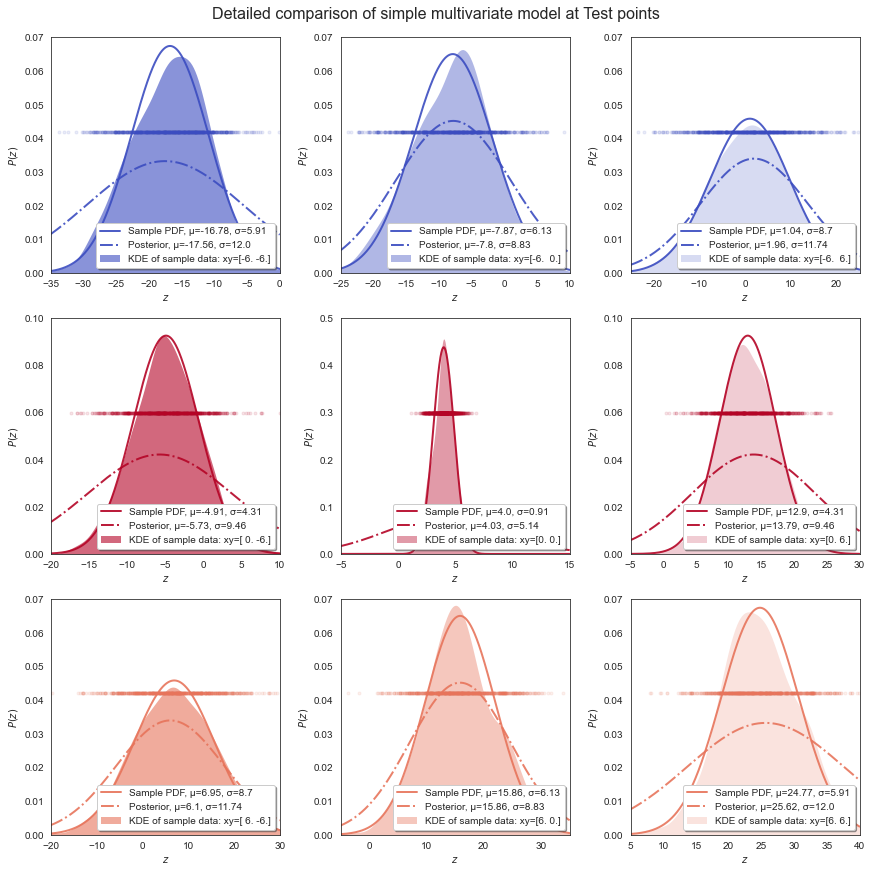

In [28]:
plot_posterior_results('Posterior observations of simple multivariate model at Test points', 
                       'Posterior mean predicted points', xy_test, mv_linear_pred.T[:,:600], μ_post_i_f, σ_post_i_f, μ_post_β_f, Σ_post_β_f, 1, True)
plot_pdf_details(xy_obs, z_obs, 'Detailed comparison of simple multivariate model at Test points', 'Posterior', μ_post_i_f, σ_post_i_f, μ_post_β_f, Σ_post_β_f)

## 6. Conclusion
Machine learning is the extraction of signal from noise, not just line fitting, and our claim as Bayesians is that there is physical significance to the probability distributions of priors and posteriors.

The great power of Bayesian inference is its ability to learn the complex properties of apparently noisy data and model not just the mean but also the probability densities of the observed data. This allows for further interpretation, risk and cost analysis, decision making and planning. In many industries, such as medical research and oil exploration, it is vital to work with uncertainties in action planning based on uncertain data.

Here we have interpreted the data, and corresponding model, as a collection of true trajectories, each with fixed intercept and slope and associated multivariate probability distributions.

1. We have shown that variances in the uncertainties in our simulated data are correctly modelled by our prior distributions and that we can reliably reproduce the values of our simulated intercept and slope mean and covariance.

2. Going forward we can investigate patterns of non-homogeneous linear data points that can be grouped, where points in each group are derived from the same linear trajectory, hence breaking our modelled posteriors into multimodal distributions, which is the basis of linear mixed models.

3. We can seek to learn more granular complex models of the distributions for intercept and slope and seek to resolve these uncertainties into more fundamental uncertainties, possibly using latent variables, giving greater understanding of the underlying deterministic processes.

We do not suggest that there is a single interpretation of linear regression which is right or wrong but that we should look for an interpretation which allows the greatest richness in uncovering the properties of observable systems. By strictly implementing dynamic, deterministic, causal models, Bayesian methods give us a rich toolset for discovering the building blocks of a complex world.

***"a thing cannot occur without a cause... The curve described by a simple molecule is regulated in a manner just as certain as the planetary orbits; the only difference between them is that which comes from our ignorance. ... The theory of chance consists in reducing all the events of the same kind to such as we may be equally undecided about in regard to their existence."*** Pierre-Simon Laplace, Essay on Probabilities, 1795.

### 6.1 Work in Progress
1. Our method lends itself to multivariate Gaussian mixture models and hence we intend to continue to explore its power in this domain.
2. We also intend to generate experimental results varying sample sizes and the effect of changing the number of observations per sample trajectory.
3. We have modelled correlations in slope but this does not tell us anything about the shape of the sample data points in the xy domain. We will add and investigate a correlation model which allows for distributions in the x, y plane of the sample data.
4. We intend to investigate the effect of conventional random noise added to observations and we believe we will be able to model this noise much more accurately having separated out the full uncertainty components of the intercept and slope distributions.
5. We also intend to prove this model on existing datasets.

### References

Vassend, Olav B. (2017) Nonstandard Bayesianism: How Verisimilitude and Counterfactual Degrees of Belief Solve the Interpretive Problem in Bayesian Inference. http://philsci-archive.pitt.edu/13301/1/philsciarchive2016.pdf